# Mount Drive, Load Data from CSV File & Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/IMDB Dataset.csv")
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Dataset Splitting & Preprosessing

Extracting sentences and sentiment labels from dataset.

In [ ]:
from sklearn.model_selection import train_test_split

sentences = data['review'].values
y = data['sentiment'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.20, random_state=1000)

Converting text sequences to token sequences.

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

print(sentences_train[2])
print(X_train[2])

To make a film straddling the prequels and the "real" Star Wars trilogy would tax even a great film-maker....Mr Lucas is not that film-maker.<br /><br />To portray the fall of a good man into darkness needs a good actor...Mr Christensen is not that actor.<br /><br />The first 60-80 minutes are overwhelmingly boring with only a few pockets of yet more light sabre fights but there is a lack of edge because you already know which main characters survive to the original Star Wars.<br /><br />Count Dooku (Christopher Lee) has a very fleeting role here and about the best idea is to have Jar Jar Binks silent! <br /><br />No the film only picks up with the Chancellor turning on the Jedi and has one great (overlong) sequence at the lava falls
[5, 94, 3, 19, 34839, 1, 18771, 2, 1, 144, 326, 1671, 2515, 59, 6982, 57, 3, 79, 19, 2745, 441, 5033, 6, 21, 12, 19, 2745, 7, 7, 5, 2069, 1, 785, 4, 3, 49, 128, 82, 2385, 754, 3, 49, 292, 441, 13351, 6, 21, 12, 292, 7, 7, 1, 86, 3732, 2993, 226, 23, 12859,

With `maxlen` set to 256, we ensure all sentences are of uniform length. We also encode target values into integers using `LabelEncoder`.

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

maxlen = 256

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(X_train[0, :])

[   22    97    62     1   467  3537    36     3  3919   242    29     1
  3955    70    46     1  5398     1 11183     1   716  1300     1  6699
     4     1  5129     3    49  2174    15 65374  8599     2   306  2231
  6163    12   857     1  5099  1068   141    36     1 16610    81     1
   274     6   249  1114  7817    14     1  1973 65375  1064  1179  2508
     3 65376   624    93  3024    99  3290     3  3025 65377    30   299
  2210   535  2455    51  4027     5     1  1064    59    25    90     9
     3   120    51   832     2   134    78   131   103   214   186   272
   303    99     3  5398     6     9     3   418     4   280    22  1885
     1  5398    22    80    26    49    15   113    51    71   234   329
     9   277     1   573     4 26261     1  5398    15 11183     2    21
  1907 27847    20     1 20129    35    23  1189     1   845    15     3
 26262     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

Using matrices of 100 dimensions for each word and storing the embedding matrix extracted from GLoVe in a variable called `embedding_matrix`

In [ ]:
import numpy as np

def create_embed(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 100
embedding_matrix = create_embed('/content/gdrive/MyDrive/glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6289039560087556

# Creating a shallow RNN model with an embedding layer, a dense layer with 10 hidden units and an output layer.

In [ ]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          11238600  
                                                                 
 dense (Dense)               (None, 256, 10)           1010      
                                                                 
 dense_1 (Dense)             (None, 256, 1)            11        
                                                                 
Total params: 11239621 (42.88 MB)
Trainable params: 11239621 (42.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Introducing gated recurrence relation to the shallow RNN model with an embedding layer, a unidirectional LSTM layer with 10 hidden units and an output layer.

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen))
model2.add(layers.LSTM(10))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          11238600  
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 11243051 (42.89 MB)
Trainable params: 11243051 (42.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Replacing the uni-directional LSTM layer with a bi-directional LSTM layer.

In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size, weights=[embedding_matrix], output_dim=embedding_dim, input_length=maxlen))
model3.add(layers.Bidirectional(layers.LSTM(10)))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 100)          11238600  
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 11247501 (42.91 MB)
Trainable params: 11247501 (42.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Training, Testing and Visualizing Results

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    lb = '#7ce1fa'
    o = '#fe9422'

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, lb, label='Training acc')
    plt.plot(x, val_acc, o, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, loss, lb, label='Training loss')
    plt.plot(x, val_loss, o, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [ ]:
shallow_rnn = model.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy * 100))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy * 100))

Training Accuracy: 54.9433%
Testing Accuracy:  53.8754%


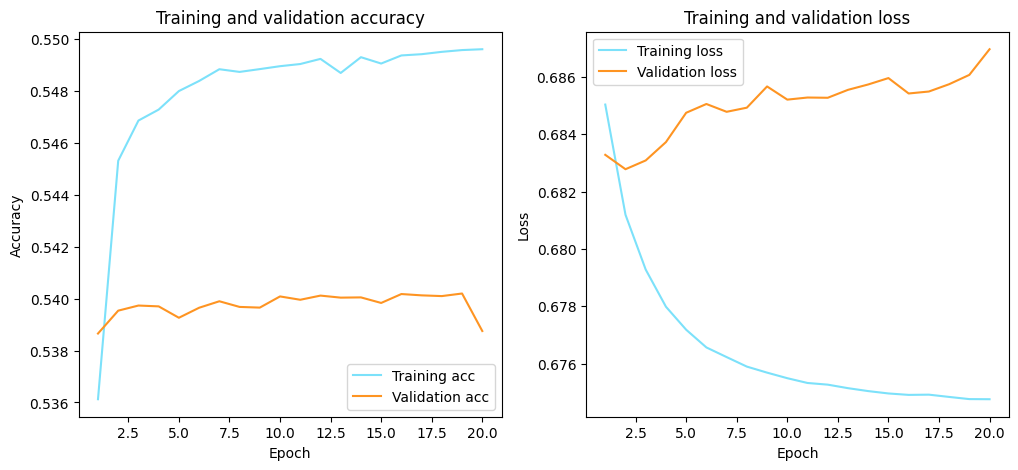

In [ ]:
plot_history(shallow_rnn)

In [ ]:
from keras.backend import clear_session
clear_session()

In [ ]:
uni_LSTM = model2.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)

loss, accuracy = model2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy * 100))
loss, accuracy = model2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy * 100))

Training Accuracy: 100.0000%
Testing Accuracy:  85.6300%


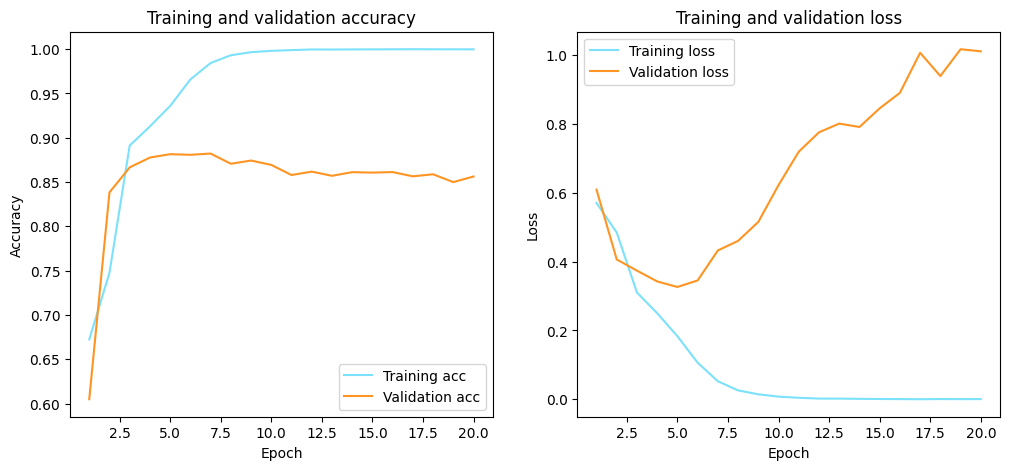

In [ ]:
plot_history(uni_LSTM)

In [ ]:
clear_session()

In [ ]:
bi_LSTM = model3.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_test, y_test), batch_size=10)

loss, accuracy = model3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}%".format(accuracy * 100))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy * 100))

Training Accuracy: 100.0000%
Testing Accuracy:  86.8500%


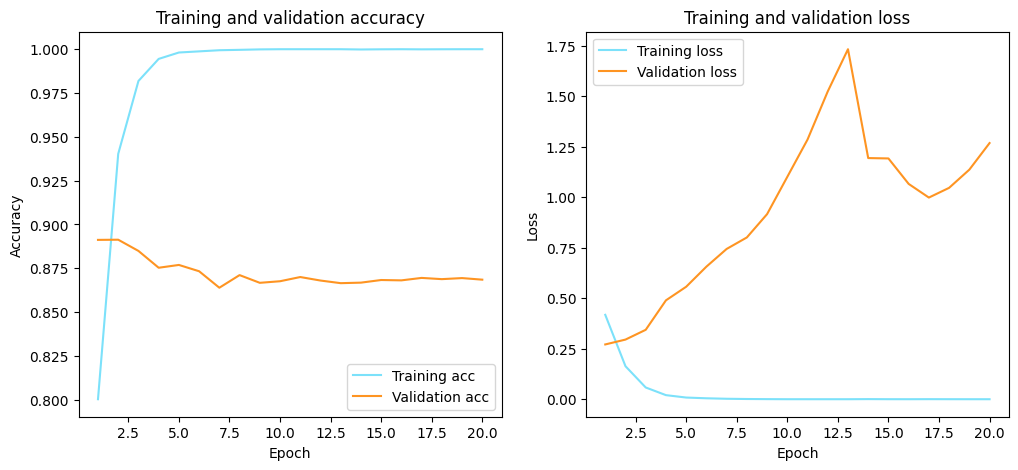

In [ ]:
plot_history(bi_LSTM)

In [ ]:
clear_session()